# 00_Relative_Position_Bias

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import scanpy as sc
import pysam
import os
from ast import literal_eval

In [4]:
colon_dna_fn = '/broad/thechenlab/pipeline_slidetag/data/240609_SL-EXC_0308_A22KHFYLT3/count'
colon_rna_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger'
colon_spatial_fn = '/broad/thechenlab/Andy/slide_tag_dna/colon_droplet/data/Mehdi_smaht_153_celltypes_locations.csv'
# bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger/xBO153_GEX_240625/outs/possorted_genome_bam.bam' # RNA
bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam' 
maf_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.txt'

In [5]:
colon_spatial_df = pd.read_csv(colon_spatial_fn, sep=',', index_col=0)

In [6]:
colon_spatial_df.head()

,cell_type,x,y,cell_type_broad
AAACCGAAGGCAATAG-1,Intermediate Epithelial,NaN,NaN,Epithelial
AAACCGAAGTATCGCG-1,Progenitor Epithelial,4639.436632,3248.049118,Epithelial
AAACCGGCATCTTGAG-1,T cell,NaN,NaN,Immune
AAACGCGCATGGAGGC-1,Fibroblast_1,2043.568952,1025.101805,Stromal
AAACGGATCATGCTTT-1,Goblet,4539.478596,3205.408255,Epithelial


In [7]:
maf_df = pd.read_csv(maf_fn, sep='\t')
maf_df.head()

,Chr,Pos,Ref,Alt,NV,NR,VAF
0,chr1,16856,A,G,5,44,0.113636
1,chr1,108540,A,C,7,44,0.159091
2,chr1,127491,T,G,16,70,0.228571
3,chr1,268043,C,T,11,78,0.141026
4,chr1,275337,T,C,6,55,0.109091


1. Mutation calls with Mutect2 from Tim. Want to deconvolve the mutation calling to each of the individual cells
1. Once mutations have been called between cells, can link them to the spatial locations. Perform moran's I or other spatial permutation tests
    1. we expect germline to be high VAF (in bulk) and everywhere
    1. somatic mutations to be low VAF (in bulk) and in specific locations?
    1. artifacts might be doing something else

In [8]:
maf_df.head()

,Chr,Pos,Ref,Alt,NV,NR,VAF
0,chr1,16856,A,G,5,44,0.113636
1,chr1,108540,A,C,7,44,0.159091
2,chr1,127491,T,G,16,70,0.228571
3,chr1,268043,C,T,11,78,0.141026
4,chr1,275337,T,C,6,55,0.109091


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

For each mutation:
- record distribution of the relative location of the mutation on the read (don't need to differentiation between alt and ref)
- for all the reads piled up on this region, where is the relative location of the genomic position on these reads


In [10]:
annot_maf_fn = f'/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.annot_mut_read_pos.txt'
print(annot_maf_fn)

/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.annot_mut_read_pos.txt


In [13]:
if not os.path.exists(annot_maf_fn):
    annot_maf_df = maf_df.copy()

    with pysam.AlignmentFile(bam_fn, "rb") as bam:
        annot_maf_df['alt_relative_positions'] = np.nan
        annot_maf_df['alt_relative_positions'] = annot_maf_df['alt_relative_positions'].astype(object)
        for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
            chrom = r['Chr']
            pos = r['Pos']
            ref_base = r['Ref']
            alt_base = r['Alt']

            num_reads = 0
            num_alt_reads = 0
            alt_relative_positions = []
            for read in bam.fetch(chrom, pos - 1, pos):  # Fetch reads overlapping mutation site
                if read.is_unmapped or read.is_secondary or read.is_supplementary or read.is_duplicate:
                    continue  # Skip unmapped/secondary/supplementary alignments

                aligned_pairs = read.get_aligned_pairs(matches_only=True)  # List of (read_pos, ref_pos)
                read_length = read.query_length

                for read_pos, ref_pos in aligned_pairs:
                    if ref_pos == pos - 1:  # 0-based in pysam
                        read_base = read.query_sequence[read_pos]

                        if read_base == alt_base:  # Mutation is present in read
                            alt_relative_positions.append(read_pos / read_length)  # Normalize to read length
                            num_alt_reads += 1
                        break  # No need to check further in this read

                num_reads += 1

            annot_maf_df.loc[i, 'num_reads'] = num_reads
            annot_maf_df.loc[i, 'num_alt_reads'] = num_alt_reads
            annot_maf_df.at[i, 'alt_relative_positions'] = alt_relative_positions

    annot_maf_df.to_csv(annot_maf_fn, sep='\t', index=None)

In [20]:
annot_maf_df = pd.read_csv(annot_maf_fn, sep='\t')
annot_maf_df['alt_relative_positions'] = annot_maf_df['alt_relative_positions'].apply(literal_eval) # string to list

In [23]:
all_alt_relative_positions = np.concatenate([np.array(r['alt_relative_positions']) for i, r in annot_maf_df.dropna(subset='alt_relative_positions').iterrows()])

(array([10.,  0.,  1.,  5., 12., 10.,  7., 10., 12., 13.]),
 array([0.04819277, 0.14270683, 0.23722088, 0.33173494, 0.426249  ,
        0.52076305, 0.61527711, 0.70979116, 0.80430522, 0.89881928,
        0.99333333]),
 <BarContainer object of 10 artists>)

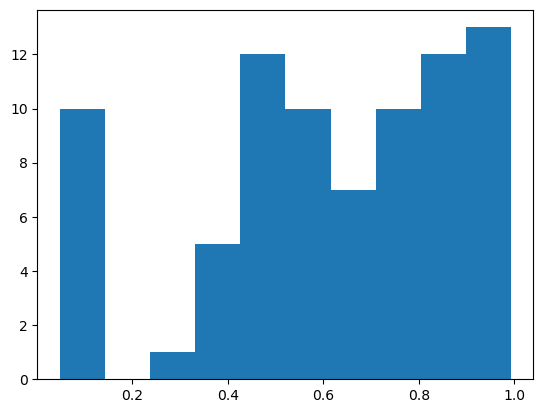

In [25]:
plt.hist(np.array([float(x) for x in annot_maf_df.loc[68878, 'alt_relative_positions']]))

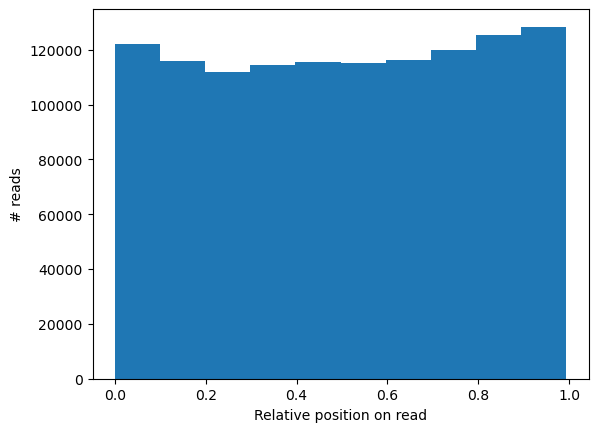

In [26]:
plt.hist(all_alt_relative_positions)
plt.ylabel('# reads')
plt.xlabel('Relative position on read')
plt.show()

Check read lengths (10x trims already?)

In [41]:
annot_maf_df['type'] = 'SNP'
annot_maf_df.loc[annot_maf_df['Alt'].str.len() > 1, 'type'] = 'INS'
annot_maf_df.loc[annot_maf_df['Ref'].str.len() > 1, 'type'] = 'DEL'

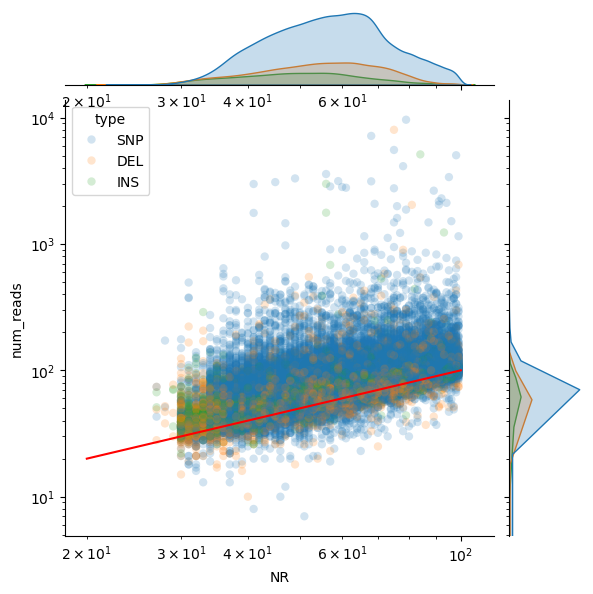

In [44]:
sns.jointplot(annot_maf_df, x='NR', y='num_reads', linewidth=0, alpha=0.2, hue='type')
plt.plot([20, 100], [20, 100], c='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

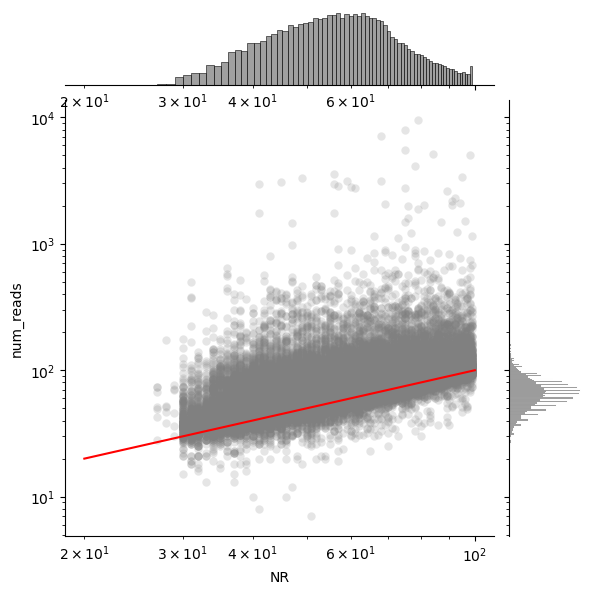

In [28]:
sns.jointplot(annot_maf_df, x='NR', y='num_reads', linewidth=0, alpha=0.2, color='gray')
plt.plot([20, 100], [20, 100], c='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

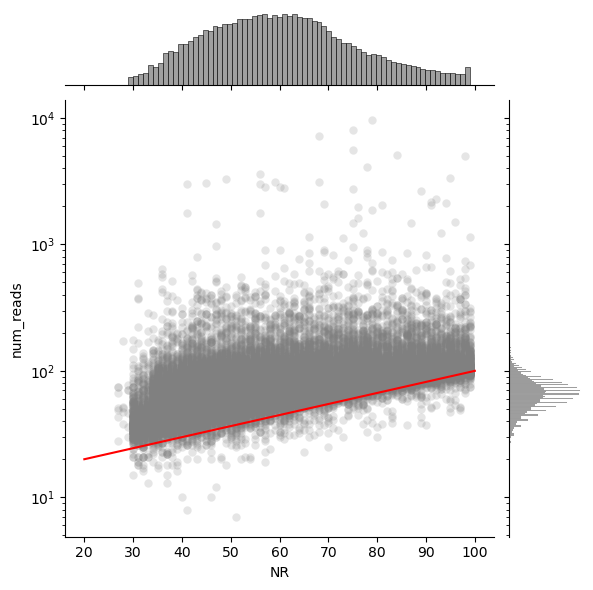

In [29]:
sns.jointplot(annot_maf_df, x='NR', y='num_reads', linewidth=0, alpha=0.2, color='gray')
plt.plot([20, 100], [20, 100], c='r')
plt.yscale('log')
plt.show()

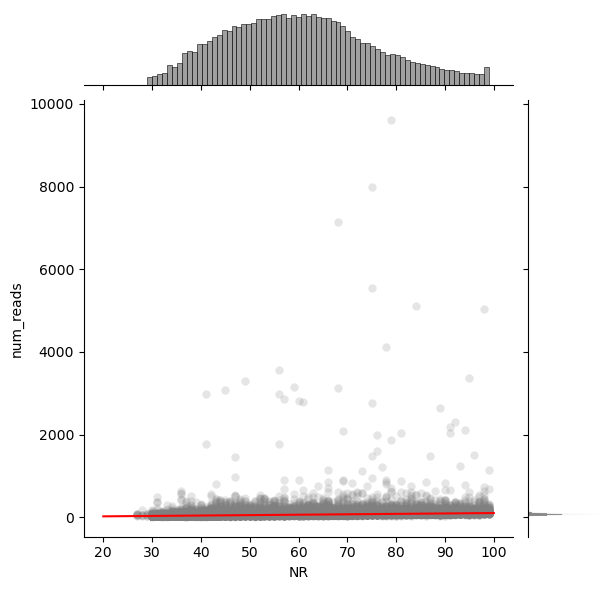

In [30]:
sns.jointplot(annot_maf_df, x='NR', y='num_reads', linewidth=0, alpha=0.2, color='gray')
plt.plot([20, 100], [20, 100], c='r')
# plt.yscale('log')
plt.show()

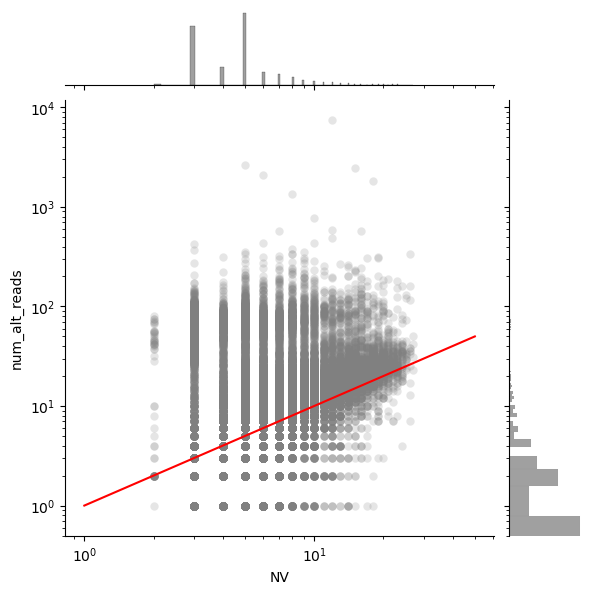

In [31]:
sns.jointplot(annot_maf_df, x='NV', y='num_alt_reads', linewidth=0, alpha=0.2, color='gray')
plt.plot([1, 50], [1, 50], c='r')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [45]:
read.to_dict()

{'name': 'lh00125:292:22KHFFLT3:4:1189:25410:2506_GCTACTCACGTAATGC',
 'flag': '99',
 'ref_name': 'chr1',
 'ref_pos': '231933898',
 'map_quality': '60',
 'cigar': '9=1X140=',
 'next_ref_name': '=',
 'next_ref_pos': '231934040',
 'length': '292',
 'seq': 'CCTTGAGACTGGCACTACTTGGAAACATGACTGGCTATTTCTGCTGCAGGATTCCTGGTCCGGGCTCCAGCAAAATTATTGTTGTGAACATAGGCCTTGAAGAGGAGGCTGAAGCCGAGAAGCCAATATTCACTCACCTTTTCAACCTTC',
 'qual': 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
 'tags': ['NM:i:1',
  'AS:i:290',
  'nn:i:0',
  'tp:A:P',
  'cm:i:22',
  's1:i:254',
  's2:i:0',
  'de:f:0.0067',
  'rl:i:0',
  'CB:Z:GCTACTCACGTAATGC',
  'MQ:i:60',
  'MC:Z:110=1X39=',
  'ms:i:6000']}